# Iterators

`for` loops "lower" to `while` loops plus calls to the `iterate` function:

```jl
for i in iter   # or  "for i = iter" or "for i ∈ iter"
    # body
end
```

internally works the same as:

```jl
next = iterate(iter)
while next !== nothing
    (i, state) = next
    # body
    next = iterate(iter, state)
end
```

The same applies to comprehensions and generators.

Note `nothing` is a singleton value (the only value of its type `Nothing`) used by convention when there is no value to return (a bit like `void` in C). For example 

In [ ]:
typeof(print("hello"))

In [ ]:
A = ['a','b','c'];

In [ ]:
iterate(A)

In [ ]:
iterate(A, 2)

In [ ]:
iterate(A, 3)

In [ ]:
iterate(A, 4)

Iteration is also used by "destructuring" assignment:

In [ ]:
x, y = A

In [ ]:
x

In [ ]:
y

Yet another user of this "iteration protocol" is so-called argument "splatting":

In [ ]:
string(A)

In [ ]:
string('a','b','c')

In [ ]:
string(A...)

## Iteration utilities

`collect` gives you all elements of an iterator as an array.
Comprehensions are actually equivalent to calling `collect` on a generator.

In [ ]:
collect(pairs(A))

In [ ]:
collect(zip(100:102,A))

Some other favorites to experiment with. These are in the built-in `Iterators` module:
- `enumerate`
- `rest`
- `take`
- `drop`
- `product`
- `flatten`
- `partition`

Some iterators are infinite!
- `countfrom`
- `repeated`
- `cycle`

In [ ]:
I = zip(Iterators.cycle(0:1), Iterators.flatten([[2,3],[4,5]]))

In [ ]:
collect(I)

In [ ]:
collect(Iterators.product(I,A))

In [ ]:
string(I...)

## Defining iterators

In [ ]:
struct SimpleRange
    lo::Int
    hi::Int
end

In [ ]:
Base.iterate(r::SimpleRange, state = r.lo) = state > r.hi ? nothing : (state, state+1)

In [ ]:
Base.length(r::SimpleRange) = r.hi-r.lo+1

In [ ]:
collect(SimpleRange(2,8))

## Iterator traits

For many algorithms, it's useful to know certain properties of an iterator up front.

The most useful is whether an iterator has a fixed, known length.

In [ ]:
Base.IteratorSize([1])

In [ ]:
Base.IteratorSize(Iterators.repeated(1))

In [ ]:
Base.IteratorSize(eachline(open("/dev/null")))

## Exercise

Define an iterator giving the first N fibonacci numbers.

In [1]:
struct FibN
    N::Int
end

Base.iterate(r::FibN, state = (n=1, f1=0, f2=1)) = state.n > r.N ? nothing : (state.f1+state.f2, (n=state.n+1, f1=state.f2, f2=state.f1+state.f2))
Base.length(r::FibN) = r.N

collect(FibN(10))


10-element Vector{Any}:
  1
  2
  3
  5
  8
 13
 21
 34
 55
 89

## Index iterators

In [2]:
A = rand(3,5)

3×5 Matrix{Float64}:
 0.371271  0.555459  0.63521   0.829367  0.233724
 0.550179  0.96242   0.989396  0.831345  0.578053
 0.767958  0.899303  0.707099  0.926742  0.364227

In [3]:
eachindex(A)

Base.OneTo(15)

In [4]:
keys(A)

CartesianIndices((3, 5))

In [5]:
Av = view(A, [1,3], [1,2,5])

2×3 view(::Matrix{Float64}, [1, 3], [1, 2, 5]) with eltype Float64:
 0.371271  0.555459  0.233724
 0.767958  0.899303  0.364227

In [6]:
A[[1,3],[1,2,5]]

2×3 Matrix{Float64}:
 0.371271  0.555459  0.233724
 0.767958  0.899303  0.364227

In [7]:
eachindex(Av)

CartesianIndices((2, 3))

### Example: $3\times 3\times \dots \times3$ boxcar filter (from a blog post by Tim Holy)

In [8]:
function boxcar3(A::AbstractArray)
    out = similar(A)
    R = CartesianIndices(size(A))
    I1, Iend = first(R), last(R)
    for I in R
        n, s = 0, zero(eltype(out))
        for J in CartesianIndices(map(:, max(I1, I-I1).I, min(Iend, I+I1).I))
            s += A[J]
            n += 1
        end
        out[I] = s/n
    end
    out
end

boxcar3 (generic function with 1 method)

In [9]:
using Images

In [10]:
A = rand(256,256);

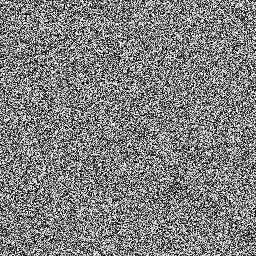

In [11]:
Gray.(A)

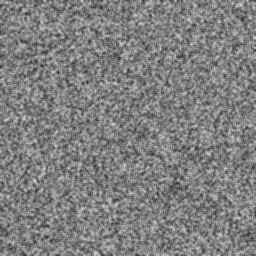

In [12]:
Gray.(boxcar3(A))

In [13]:
function sumalongdims!(B, A)
    # It's assumed that B has size 1 along any dimension that we're summing
    fill!(B, 0)
    Bmax = CartesianIndex(size(B))
    for I in CartesianIndices(size(A))
        B[min(Bmax,I)] += A[I]
    end
    B
end

sumalongdims! (generic function with 1 method)

In [14]:
B = zeros(1, 256)

1×256 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [15]:
sumalongdims!(B, A)

1×256 Matrix{Float64}:
 123.631  120.305  122.153  125.775  …  128.351  129.115  134.549  121.456

In [16]:
reduce(+,A,dims=(1,))

1×256 Matrix{Float64}:
 123.631  120.305  122.153  125.775  …  128.351  129.115  134.549  121.456

`CartesianIndices` and other "N-d" iterators have a shape that propagates through generators.

In [17]:
[1 for i in CartesianIndices((2,3))]

2×3 Matrix{Int64}:
 1  1  1
 1  1  1

In [18]:
B = rand(5,5)

5×5 Matrix{Float64}:
 0.405034  0.978356  0.467889  0.317008   0.495803
 0.188983  0.944665  0.963146  0.0957896  0.837328
 0.4548    0.695531  0.501391  0.892134   0.603329
 0.303099  0.296792  0.463748  0.726411   0.60274
 0.731233  0.26097   0.4029    0.341538   0.486823

In [19]:
view(B,CartesianIndices((2,3)))

2×3 view(::Matrix{Float64}, Base.OneTo(2), Base.OneTo(3)) with eltype Float64:
 0.405034  0.978356  0.467889
 0.188983  0.944665  0.963146

## Exercise: CartesianIndex life!

- Write a function `neighborhood(A::Array, I::CartesianIndex)` that returns a view of the 3x3 neighborhood around a location
- Write a function `liferule(A, I)` that implements the evolution rule of Conway's life cellular automaton:
  - 2 live neighbors $\rightarrow$ stay the same
  - 3 live neighbors $\rightarrow$ 1
  - otherwise $\rightarrow$ 0
- Write a function `life(A)` that maps A to the next life step using these

Some famous initial conditions:

In [ ]:
A = fill(0, 128,128);

In [ ]:
A[61:63,61:63] = [1 1 0
                  0 1 1
                  0 1 0]

In [ ]:
A = life(A)
# `repeat` can be used to get chunky pixels to make the output easier to see
Gray.(repeat(A,inner=(4,4)))